# Финальное задание NLP-2. Рекуррентные нейронные сети

Теперь вы можете самостоятельно написать рекуррентную нейронную сеть для задачи NER, решающую задачу с достаточно высоким качеством.

В рамках этого задания вы отработаете навыки:

*   Построения словаря слов
*   Загрузки предобученных весов и использовании их для построения корпуса текста
*   Написания двунаправленной рекуррентной нейронной сети

## Установка зависимостей

Тут есть важное действие, которое тебе нужно сделать перед тем, как запускать этот ноутбук.

Если вы делаете это задание в Google Colab, первым делом переключите Runtime в GPU. Это задание нормально посчитается и на CPU, но некоторые из будущих кейсов потребуют GPU (либо вам придётся несколько часов, или даже дней, чтобы модель обучилась — и мы не преувеличиваем). Ещё мы рекомендуем переключить язык интерфейса Colab на английский, потому что русская локализация ужасна, да и вообще не нужна.

[Тут](https://www.geeksforgeeks.org/how-to-use-google-colab/) о том, как переключить рантайм.

Как обычно, установим недостающие библиотеки:

In [ ]:
!pip install datasets > /dev/null
!pip install fasttext > /dev/null

In [ ]:
import pytest
from datasets import load_dataset
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional, Union
from torch.utils.data import Dataset
from torch.optim import Adam
import time
from tqdm import tqdm

from collections import Counter

## Векторное представление слов

В прошлом модуле вы познакомились с представлением слова как векторов. 
В этом задании мы будем использовать веса из библиотеки Fasttext.

В качестве данных для задачи NER будем использовать уже рассмотренный нами ранее датасет conll2003, содержащий сущности 4ех разных классов — личности, организации, места и национальности.

In [ ]:
dataset_base = load_dataset("conll2003")

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_base['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

Загрузим веса модели (это может занять примерно 25 минут, веса весят 6GB).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !curl https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz --output /content/drive/MyDrive/cc.en.300.bin.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4294M  100 4294M    0     0  28.0M      0  0:02:33  0:02:33 --:--:-- 28.3M


In [ ]:
!cp ./drive/MyDrive/cc.en.300.bin.gz ./

In [ ]:
!gzip -d cc.en.300.bin.gz

In [ ]:
ls

cc.en.300.bin  drive/  sample_data/


In [ ]:
import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # English

Загрузите fasttext модель cc.en.300.bin:

In [ ]:
# Домашнее задание
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
assert ft is not None
assert ft['Cat'].shape[0] == 300
assert ft['Cat'].sum() < -2.3 and ft['Cat'].sum() > -2.4

In [ ]:
def get_word_to_idx(count: List[Tuple[str, int]],
                   min_words: Union[int, float] = 0.0,
                   max_words: Union[int, float] = 1.0) -> Dict[str, int]:
    max_count = count[0][1]
    if isinstance(min_words, float):
        min_words = max_count * min_words
    if isinstance(max_words, float):
        max_words = max_count * max_words
        
    all_words = [w[0] for w in count if max_words >= w[1] >= min_words]
    
    all_words = ['<pad>', '<unk>'] + all_words
    
    word_to_idx = {k: v for k, v in zip(all_words, range(0, len(all_words)))}
    return word_to_idx

Проинициализируйте словарь word_to_idx, убрав слова, встречающиеся больше 100 раз:

In [ ]:
count = Counter([i for j in dataset_base['train'] for i in j['tokens']])

In [ ]:
from collections import Counter

In [ ]:
# Домашнее задание
toks = []
for i in dataset_base['train']['tokens']:
  toks+=i

count = Counter(toks)

for key, value in list(count.items()): 
    if value > 100:
        del count[key]

word_to_idx = get_word_to_idx(count.most_common())

In [ ]:
assert isinstance(count, Counter)
assert len(word_to_idx) < 23500 
assert word_to_idx['MANCHESTER'] == 1521

Посмотрим на длину словаря:

In [ ]:
len(word_to_idx)

23439

Оствавим часто встречаемые слова, потому что среди них может встречаться наши прогнозируемые токены:

In [ ]:
# count = Counter([i for j in dataset_base['train'] for i in j['tokens']])
# word_to_idx = get_word_to_idx(count.most_common(), min_words=1)

In [ ]:
def build_matrix(
    word_dict: Dict,
    embedding_index,
    max_features: int = 100000,
    embed_size: int = 100,
) -> Tuple[np.array, int, List]:
    """
    Create embedding matrix

    Args:
        word_dict: tokenizer
        embedding_index: Fasttext embeddings
        max_features: max features to use
        embed_size: size of embeddings

    Returns:
        embedding matrix, number of of words and the list of not found words
    """
    embedding_index = ft
    nb_words = min(max_features, len(word_dict))
    embedding_matrix = np.zeros((nb_words, embed_size))

    for word, i in word_dict.items():
        embedding_matrix[i] = embedding_index[word]
    return embedding_matrix, nb_words

Теперь проинициализируйте матрицу embedding_matrix с использованием функции build_matrix:

In [ ]:
# Домашнее задание
embedding_matrix, nb_words = build_matrix(word_to_idx, ft, 100000, 300)

In [ ]:
assert embedding_matrix.shape[0] == len(word_to_idx)
assert embedding_matrix[42].sum() > -1

In [ ]:
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

## Реализация модели RNN

Как обычно, проверим распределение длин тренировочных текстов:

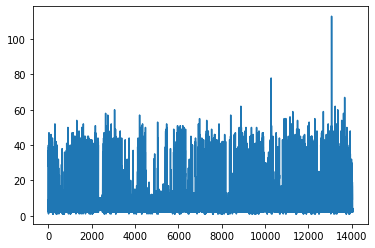

In [ ]:
import pandas as pd
import numpy as np


max_lens = list()
for row in dataset_base['train']:
    max_lens.append(len(row['tokens']))
max_lens = pd.Series(max_lens)
max_lens.plot();

In [ ]:
import json
mapping_ = {v: k for k, v in dataset_base["train"].features["ner_tags"].feature._str2int.items()}

with open('mapping.json', 'w') as f:
  json.dump(mapping_, f)

Теперь заполните недостающую строчку в функции create_matrix_of_texts, так, чтобы при попадании неизвестного слова в матрице ставился индекс неизвестного слова:

In [ ]:
# Домашнее задание

def create_matrix_of_texts(dataset, max_sequence_length, 
                           pad_token, word2index):
    texts = np.full((len(dataset), max_sequence_length),
                    word2index[pad_token], dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row['tokens']))
          text = row['tokens'][: trim_length]
          # YOUR CODE HERE
          texts[ind, : trim_length] = [word2index.get(item.lower(), word2index['<unk>']) for item in text] 
          # END OF YOUR CODE
    return texts


def create_matrix_of_tags(dataset, max_sequence_length, pad_index):
    tags = np.full((len(dataset), max_sequence_length),
                    pad_index, dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row['ner_tags']))
          labels = row['ner_tags'][: trim_length]
          tags[ind, : trim_length] = [item for item in labels]
    return tags

In [ ]:
texts = create_matrix_of_texts(dataset_base['train'], 
                               int(max_lens.quantile(0.97)),
                               '<pad>', word_to_idx)
tags = create_matrix_of_tags(dataset_base['train'],
                             int(max_lens.quantile(0.97)), 0)

In [ ]:
text_for_check = create_matrix_of_texts(dataset_base['validation'], 
                                        int(max_lens.quantile(0.97)),
                                        '<pad>', word_to_idx)
assert text_for_check[0][2] == 1
# assert text_for_check[23].sum() == 40986

Напишем класс для загрузки датасета:

In [ ]:
class NerDataset(Dataset):
    def __init__(self,
                 texts: np.array,
                 tags: np.array):
        self.tags = tags
        self.texts = texts
        

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens_tensor = torch.tensor(self.texts[idx], dtype=torch.int64)
        return tokens_tensor, torch.tensor(self.tags[idx], dtype=torch.int64)

    def __len__(self) -> int:
        dataset_len = self.texts.shape[0]
        return dataset_len

In [ ]:
dataset = dataset_base['train']
ner_dataset = NerDataset(texts, tags)

In [ ]:
' '.join(dataset_base['train'][0]['tokens']), ner_dataset[0]

('EU rejects German call to boycott British lamb .',
 (tensor([    1, 11798,     1,   577,     1,  3962,     1,  5997,     1,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
  tensor([3, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])))

Разобьем текст на тренировочную и валидационную часть:

In [ ]:
from torch.utils.data.dataset import random_split

In [ ]:
BATCH_SIZE = 32

In [ ]:
num_train = int(len(ner_dataset) * 0.95)
split_train_, split_valid_ = random_split(ner_dataset, [num_train, len(ner_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=False)

Наша нейронная сеть будет принимать в качестве слоя эмбеддинга предобученные веса из библиотеки fasttext, а в качестве промежуточного вычислительного звена будем использовать двунаправленную двухслойную рекуррентную сеть. Схематично ее можно изобразить как на рисунке.

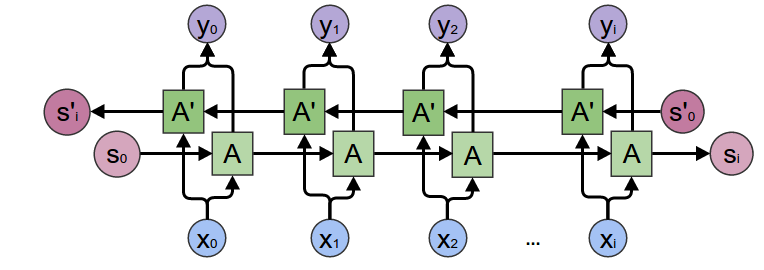

Перейдем к созданию матрицы.

Создайте класс сети RNN, у которого в слой эмбеддинга будет проинициализирован матрицей загруженных весов, а слой рекуррентной сети будет иметь параметры num_layers=1 и быть двунаправленным.
Так как мы будем использовать двунаправленный рекуррентный блок, то входная размерность выходного слоя должна быть в два раза больше чем размер скрытого состояния.  

In [ ]:
# Домашнее задание
class NerRNNModel(nn.Module):
    def __init__(
        self,
        pretrained_embeddings,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256
    ):
        super(NerRNNModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')

        # Vocabulary size
        self.vocab_size = pretrained_embeddings.shape[0]
        # Embedding dimensionality
        self.embedding_size = pretrained_embeddings.shape[1]
        self.labels = mapping

        # YOUR CODE HERE
        self.embedding =  nn.Embedding(pretrained_embeddings.shape[0], pretrained_embeddings.shape[1])
        self.embedding.weight.data = pretrained_embeddings  
        # END OF YOUR CODE
        
        self.embedding.requires_grad_(True)  # дообучим под свою задачу

        # YOUR CODE HERE
        self.encoder = nn.RNN(
            pretrained_embeddings.shape[1],
            hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            )
        encoder_output_value = hidden_size * 2
        # END OF YOUR CODE

        self.projection = nn.Linear(encoder_output_value, len(mapping))
        
    def forward(self, tokens: LongTensor) -> FloatTensor:
        emb = self.embedding(tokens)        
        h, _ = self.encoder(emb)
        pred = self.projection(h)
        return pred.view(-1, len(self.labels))

## Обучение модели

In [ ]:
from sklearn.metrics import classification_report

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in mapping_.values() if value != 'O']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               40,
                                                               len(mapping_)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    
    true_labels = [mapping_[val] for val in true_labels]
    
    predicted = [mapping_[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

Создайте экземпляр класса сети с размером скрытого слоя равным 256.

Затем создайте оптимизатор.

Не забудьте перенести созданную модель на видеокарту для ускорения обучения!

In [ ]:
# Домашнее задание

model = NerRNNModel(embedding_matrix, mapping_, 256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

NerRNNModel(
  (embedding): Embedding(23439, 300)
  (encoder): RNN(300, 256, batch_first=True, bidirectional=True)
  (projection): Linear(in_features=512, out_features=9, bias=True)
)

In [ ]:
assert sum([params.numel() for params in model.parameters() if params.requires_grad]) > 7_000_000
assert sum([params.numel() for params in model.parameters() if params.requires_grad]) < 7_500_000

Так как мы загружали уже предобученные веса, для сходимости к хорошему качеству нашей сети нужно меньше эпох, чем если бы мы обучали сеть с нуля.

In [ ]:
for e in range(4):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for sent in tqdm(train_dataloader):

            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model.zero_grad()
            
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent

            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != 0
                # (4) Compute loss and do backward step
                loss = loss_function(pred_scores.to(device), gold_tags.view(-1).to(device))
                loss.backward()
              
                # (5) Optimize parameter values
                optimizer.step()
          
                # (6) Accumulate loss
                total_loss += loss
    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
    evaluate(valid_dataloader)

100%|██████████| 416/416 [00:05<00:00, 70.69it/s]



Epoch: 0, loss: 0.2774

               precision    recall  f1-score   support

       B-PER       0.84      0.12      0.21       304
       I-PER       0.35      0.04      0.07       183
       B-ORG       0.75      0.01      0.02       316
       I-ORG       0.33      0.06      0.10       169
       B-LOC       0.58      0.05      0.10       358
       I-LOC       0.00      0.00      0.00        59
      B-MISC       0.43      0.14      0.21       145
      I-MISC       0.43      0.28      0.34        43

   micro avg       0.52      0.07      0.12      1577
   macro avg       0.46      0.09      0.13      1577
weighted avg       0.57      0.07      0.11      1577



100%|██████████| 416/416 [00:05<00:00, 76.61it/s]



Epoch: 1, loss: 0.2240

               precision    recall  f1-score   support

       B-PER       0.74      0.13      0.22       304
       I-PER       0.68      0.21      0.32       183
       B-ORG       0.27      0.38      0.31       316
       I-ORG       0.41      0.28      0.33       169
       B-LOC       0.79      0.03      0.06       358
       I-LOC       0.75      0.10      0.18        59
      B-MISC       0.65      0.21      0.31       145
      I-MISC       0.52      0.33      0.40        43

   micro avg       0.40      0.19      0.26      1577
   macro avg       0.60      0.21      0.27      1577
weighted avg       0.60      0.19      0.24      1577



100%|██████████| 416/416 [00:05<00:00, 76.14it/s]



Epoch: 2, loss: 0.2043

               precision    recall  f1-score   support

       B-PER       0.72      0.21      0.33       304
       I-PER       0.79      0.24      0.37       183
       B-ORG       0.27      0.04      0.08       316
       I-ORG       0.52      0.15      0.24       169
       B-LOC       0.77      0.08      0.14       358
       I-LOC       0.64      0.15      0.25        59
      B-MISC       0.45      0.18      0.26       145
      I-MISC       0.47      0.37      0.42        43

   micro avg       0.58      0.14      0.23      1577
   macro avg       0.58      0.18      0.26      1577
weighted avg       0.59      0.14      0.22      1577



100%|██████████| 416/416 [00:05<00:00, 75.82it/s]



Epoch: 3, loss: 0.1957

               precision    recall  f1-score   support

       B-PER       0.70      0.25      0.37       304
       I-PER       0.57      0.37      0.45       183
       B-ORG       0.50      0.20      0.29       316
       I-ORG       0.48      0.21      0.29       169
       B-LOC       0.83      0.22      0.35       358
       I-LOC       0.52      0.19      0.27        59
      B-MISC       0.52      0.17      0.26       145
      I-MISC       0.53      0.37      0.44        43

   micro avg       0.60      0.24      0.34      1577
   macro avg       0.58      0.25      0.34      1577
weighted avg       0.62      0.24      0.34      1577



Добейтесь качества обучаемой модели не ниже 0.87 по метрике weighted avg f1-score, чтобы задание считалось успешно выполненным.

# Финальное задание NLP-2. Рекуррентные нейронные сети

Теперь, когда вы изучили GRU и LSTM, вы готовы к решению задач NER с использованием подобных более продвинутых архитектур.

В рамках данного задания вы отработаете навыки:
- Работы с нетиповыми данными
- Построения словаря слов
- Написания двунаправленной рекуррентной нейронной сети на основе изученных архитектур<br>

В итоге вы напишете рекуррентную нейронную сеть для задачи NER, решающую задачу с достаточно высоким качеством.

# Загрузка данных

Загрузим данные из очень известной NLP библиотеки для работы с русским языком —  [Natasha](https://github.com/natasha/nerus).

Данные представляют из себя новости, скачанные из Lenta.ru и размеченные BIO-разметкой.

In [ ]:
!wget https://storage.yandexcloud.net/natasha-nerus/data/nerus_lenta.conllu.gz

--2021-10-20 08:17:41--  https://storage.yandexcloud.net/natasha-nerus/data/nerus_lenta.conllu.gz
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1961465886 (1.8G) [application/octet-stream]
Saving to: ‘nerus_lenta.conllu.gz.1’

nerus_lenta.conllu.  64%[===========>        ]   1.18G  9.99MB/s    eta 69s    ^C


In [ ]:
!gunzip -c nerus_lenta.conllu.gz | head

# newdoc id = 0
# sent_id = 0_0
# text = Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости.
1	Вице-премьер	_	NOUN	_	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	7	nsubj	_	Tag=O
2	по	_	ADP	_	_	4	case	_	Tag=O
3	социальным	_	ADJ	_	Case=Dat|Degree=Pos|Number=Plur	4	amod	_	Tag=O
4	вопросам	_	NOUN	_	Animacy=Inan|Case=Dat|Gender=Masc|Number=Plur	1	nmod	_	Tag=O
5	Татьяна	_	PROPN	_	Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing	1	appos	_	Tag=B-PER
6	Голикова	_	PROPN	_	Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing	5	flat:name	_	Tag=I-PER
7	рассказала	_	VERB	_	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act	0	root	_	Tag=O


Чтобы работать с данными этой библиотеки, необходимо поставить специальный модуль.

In [ ]:
!pip install nerus

Также мы будем использовать токенизатор по пунктуации, потому что именно таким образом был размечен этот датасет.

In [ ]:
import tqdm
from nerus import load_nerus
from nltk.tokenize import WordPunctTokenizer

In [ ]:
docs = load_nerus('nerus_lenta.conllu.gz')

In [ ]:
tokenizer = WordPunctTokenizer()

Посмотрим, что из себя представляют данные:

In [ ]:
doc = next(docs)
[text.text for text in doc.sents]

['Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости.',
 'По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе.',
 'Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения.',
 'В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года.',
 'По данным Росстата, в 2017 году от рака умерли 289 тысяч человек.',
 'Это на 3,5 процента меньше, чем годом ранее.']

In [ ]:
[' '.join([item.tag for item in text.tokens]) for text in doc.sents]

['O O O O B-PER I-PER O O O O O B-LOC O O O O O O O O B-ORG I-ORG O',
 'O O B-PER O O O O O O O O O B-LOC O B-LOC O B-LOC O B-LOC I-LOC O O O O B-LOC O',
 'O O O O O O O O B-LOC O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O',
 'O O B-ORG O O O O O O O O O O O',
 'O O O O O O O O O O']

In [ ]:
train_texts, train_tags = list(), list()

for i in tqdm.tqdm(range(100000)):
  doc = next(docs)
  bad_sentences = list()
  texts = [text.text for text in doc.sents]
  tags = [' '.join([item.tag for item in text.tokens]) for text in doc.sents]

  for j in range(len(tags)):
    if set(tags[j].split()) == {'O'}:
      bad_sentences.append((texts[j], tags[j]))
  
  for s, t in bad_sentences:
    texts.remove(s)
    tags.remove(t)

  if len(tokenizer.tokenize(' '.join(texts))) == len(' '.join(tags).split()) and len(tokenizer.tokenize(' '.join(texts))) < 125:
    train_texts.append(' '.join(texts))
    train_tags.append(' '.join(tags))

100%|██████████| 100000/100000 [03:36<00:00, 462.25it/s]


## Задание 1

Проверим что данные были загружены правильно, и проинициализируем множество тегов. <br>

Создайте set всех уникальных тегов (их должно быть мало).

In [ ]:
# Домашнее задание
tags = Counter([tag for tags in train_tags for tag in tags.split()])

Проверим правильность вашего кода:

In [ ]:
from collections import Counter
assert tags is not None
assert len(tags) == 7
assert sorted(tags)[2] == 'B-PER'
assert Counter([tag for tags in train_tags for tag in tags.split()]).most_common()[1][1] < 25000

# Предобученные эмбеддинги

Мы опять будем использовать предобученные эмбеддинги, только теперь для русского языка

In [ ]:
!pip install fasttext > /dev/null

In [ ]:
import pytest
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional, Union
from torch.utils.data import Dataset
from torch.optim import Adam
import time

from collections import Counter

## Задание 2
Скачайте предобученные эмбеддинги для русского языка:

In [ ]:
# Домашнее задание
#fasttext.util.download_model('ru', if_exists='ignore')  
!cp ./drive/MyDrive/cc.ru.300.bin.gz ./
!gzip -d cc.ru.300.bin.gz
!ls

cc.en.300.bin  drive	     nerus_lenta.conllu.gz
cc.ru.300.bin  mapping.json  sample_data


In [ ]:
ft = fasttext.load_model('cc.ru.300.bin')

Мы специально выбирали новости примерно одной длины, чтобы данные были достаточно однообразны.

count    8760.000000
mean       71.077397
std        31.080529
min         0.000000
25%        46.000000
50%        72.000000
75%        97.000000
max       124.000000
dtype: float64

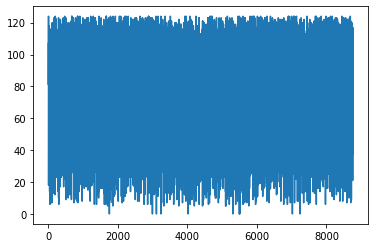

In [ ]:
import pandas as pd
import numpy as np


max_lens = list()
for row in train_texts:
    max_lens.append(len(tokenizer.tokenize(row)))
max_lens = pd.Series(max_lens)
max_lens.plot();
max_lens.describe()

Для проверки правильности вашего кода проинициализируйте переменную ```max_length``` 95% квантилем длинны всех строк, приведите ее к целому числу.

In [ ]:
# Домашнее задание
max_length = int(np.quantile(np.array(max_lens), 0.95))

In [ ]:
assert len(train_texts) == 8760
assert max_length < 120
assert max_length > 100
assert isinstance(max_length, int)

In [ ]:
def get_word_to_idx(count: List[Tuple[str, int]],
                   min_words: Union[int, float] = 0.0,
                   max_words: Union[int, float] = 1.0) -> Dict[str, int]:
    max_count = count[0][1]
    if isinstance(min_words, float):
        min_words = max_count * min_words
    if isinstance(max_words, float):
        max_words = max_count * max_words
        
    all_words = [w[0] for w in count if max_words >= w[1] >= min_words]
    
    all_words = ['<pad>', '<unk>'] + all_words
    
    word_to_idx = {k: v for k, v in zip(all_words, range(0, len(all_words)))}
    return word_to_idx

In [ ]:
count = Counter([i.lower() for j in train_texts for i in tokenizer.tokenize(j)])
word_to_idx = get_word_to_idx(count.most_common(), min_words=1, max_words=100)

In [ ]:
len(word_to_idx)

73414

In [ ]:
tag_to_idx = {v: k for k, v in enumerate(set([tag for tags in train_tags for tag in list(set(tags.split()))]))}
tag_to_idx

{'B-LOC': 0,
 'B-ORG': 1,
 'B-PER': 4,
 'I-LOC': 6,
 'I-ORG': 3,
 'I-PER': 2,
 'O': 5}

## Задание 3
Напишите функцию по построению матрицы, использующую прдобученные эмбеддинги.

In [ ]:
# Домашнее задание
def build_matrix(
    word_dict: Dict,
    embedding_index,
    max_features: int = 100000,
    embed_size: int = 100,
) -> Tuple[np.array, int, List]:

    embedding_index = ft
    nb_words = min(max_features, len(word_dict))
    embedding_matrix = np.zeros((nb_words, embed_size))

    for word, i in word_dict.items():
        embedding_matrix[i] = embedding_index[word]
    return embedding_matrix, nb_words

In [ ]:
embedding_matrix, nb_words = build_matrix(word_dict=word_to_idx,
                                          embedding_index=ft,
                                          embed_size=300)

Проверим, корректно ли работает функция:

In [ ]:
assert embedding_matrix.shape[0] < 75000
assert nb_words > 8 ** 3
assert embedding_matrix[42].sum(axis=0) > -2

In [ ]:
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

## Задание 4
Напишите функцию по созданию матрицы текстов и матрицы тегов. Не забудьте, что нужно использовать токенизацию при разбиении текстов новостей.

In [ ]:
# Домашнее задание

def create_matrix_of_texts(dataset, max_sequence_length, 
                           pad_token, word2index):
    texts = np.full((len(dataset), max_sequence_length),
                    word2index[pad_token], dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(tokenizer.tokenize(row.lower())))
          text = tokenizer.tokenize(row.lower())
          text = text[:trim_length] # ADD CODE HERE
          texts[ind, : trim_length] = [word2index.get(item.lower(), word2index['<unk>']) for item in text] # ADD CODE HERE
    return texts


def create_matrix_of_tags(dataset, max_sequence_length, pad_index, tag2index):
    tags = np.full((len(dataset), max_sequence_length),
                    pad_index, dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row.split()))
          labels = [tag_to_idx.get(i, tag_to_idx['O']) for i in row.split() ][:trim_length] # ADD CODE HERE
          tags[ind, : trim_length] = labels # ADD CODE HERE
    return tags

In [ ]:
texts_matrix = create_matrix_of_texts(train_texts, 
                               max_length,
                               '<pad>', word_to_idx)
tags_matrix = create_matrix_of_tags(train_tags,
                             max_length, tag_to_idx['O'], tag_to_idx)

In [ ]:
# assert tags_matrix[6].sum() == 23
assert texts_matrix[2029].mean() > 4500
assert texts_matrix.shape[1] == max_length

# Загрузка датасета

Объединим матрицы текстов и матрицы тегов в обучающий датасет, используя знакомый вам класс загрузки датасетов.

In [ ]:
class NerDataset(Dataset):
    def __init__(self,
                 texts: np.array,
                 tags: np.array):
        self.tags = tags
        self.texts = texts
        

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens_tensor = torch.tensor(self.texts[idx], dtype=torch.int64)
        return tokens_tensor, torch.tensor(self.tags[idx], dtype=torch.int64)

    def __len__(self) -> int:
        dataset_len = self.texts.shape[0]
        return dataset_len

In [ ]:
dataset = train_tags
ner_dataset = NerDataset(texts_matrix, tags_matrix)

In [ ]:
idx_to_tag = {second: first for first, second in tag_to_idx.items()}

In [ ]:
from torch.utils.data.dataset import random_split

In [ ]:
BATCH_SIZE = 64

In [ ]:
num_train = int(len(ner_dataset) * 0.9)
split_train_, split_valid_ = \
    random_split(ner_dataset, [num_train, len(ner_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True)

# Обучение модели

## Задание 5
Создайте свою нейронную сеть. Попробуйте разные вариации архитектур RNN, посмотрите, что дает размораживание или заморозка предобученных весов.

В дальнейшем вы выберите ту модель, которая демонстрирует лучшее качество.

In [ ]:
# Домашнее задание

class NerRNNModel(nn.Module):
    def __init__(
        self,
        pretrained_embeddings,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256
    ):
        super(NerRNNModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')

        # Vocabulary size
        self.vocab_size = pretrained_embeddings.shape[0]
        # Embedding dimensionality
        self.embedding_size = pretrained_embeddings.shape[1]
        self.labels = mapping
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.embedding.requires_grad_(True)
        self.encoder = nn.RNN(
            pretrained_embeddings.shape[1],
            hidden_size,
            num_layers=5,
            batch_first=True,
            bidirectional=True,
            )
        encoder_output_value = hidden_size * 2

        self.projection = nn.Linear(encoder_output_value, len(mapping))
        
    def forward(self, tokens: LongTensor) -> FloatTensor:
        emb = self.embedding(tokens)        
        h, _ = self.encoder(emb)
        pred = self.projection(h)
        return pred.view(-1, len(self.labels))

In [ ]:
idx_to_word = {second: first for first, second in word_to_idx.items()}

In [ ]:
from sklearn.metrics import classification_report

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in idx_to_tag.values() if value != 'O']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               max_length,
                                                               len(idx_to_tag)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    
    true_labels = [idx_to_tag[val] for val in true_labels]
    
    predicted = [idx_to_tag[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

In [ ]:
model = NerRNNModel(embedding_matrix, tag_to_idx, 256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

NerRNNModel(
  (embedding): Embedding(73414, 300)
  (encoder): RNN(300, 256, num_layers=5, batch_first=True, bidirectional=True)
  (projection): Linear(in_features=512, out_features=7, bias=True)
)

In [ ]:
sum([params.numel() for params in model.parameters() if params.requires_grad])

23890447

## Задание 6
Дополните цикл обучения:

In [ ]:
# Домашнее задание

for e in range(8):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for sent in tqdm.auto.tqdm(train_dataloader):

            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model.zero_grad() # ADD YOUR CODE inplace ...
            
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent

            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != tag_to_idx['O']
                # (4) Compute loss and do backward step
                loss = loss_function(pred_scores.to(device), gold_tags.view(-1).to(device)) # ADD YOUR CODE
                loss.backward()
              
                # (5) Optimize parameter values
                optimizer.step() # ADD YOUR CODE inplace ...
                
          
                # (6) Accumulate loss
                total_loss += loss
    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
    evaluate(valid_dataloader)

  0%|          | 0/123 [00:00<?, ?it/s]


Epoch: 0, loss: 0.4782


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



               precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00      2092
       B-ORG       0.39      0.01      0.01      2258
       I-PER       0.29      0.09      0.14      1184
       I-ORG       0.24      0.01      0.01      1810
       B-PER       0.00      0.00      0.00      1394
       I-LOC       0.00      0.00      0.00       340

   micro avg       0.29      0.02      0.03      9078
   macro avg       0.15      0.02      0.03      9078
weighted avg       0.18      0.02      0.02      9078



  0%|          | 0/123 [00:00<?, ?it/s]


Epoch: 1, loss: 0.3011

               precision    recall  f1-score   support

       B-LOC       0.49      0.29      0.36      2092
       B-ORG       0.45      0.14      0.21      2258
       I-PER       0.54      0.56      0.55      1184
       I-ORG       0.52      0.16      0.25      1810
       B-PER       0.49      0.33      0.39      1394
       I-LOC       0.00      0.00      0.00       340

   micro avg       0.50      0.26      0.34      9078
   macro avg       0.41      0.25      0.29      9078
weighted avg       0.47      0.26      0.32      9078



  0%|          | 0/123 [00:00<?, ?it/s]


Epoch: 2, loss: 0.2336

               precision    recall  f1-score   support

       B-LOC       0.72      0.47      0.57      2092
       B-ORG       0.65      0.32      0.43      2258
       I-PER       0.59      0.68      0.64      1184
       I-ORG       0.61      0.42      0.50      1810
       B-PER       0.54      0.47      0.50      1394
       I-LOC       0.75      0.02      0.03       340

   micro avg       0.63      0.43      0.51      9078
   macro avg       0.65      0.40      0.44      9078
weighted avg       0.64      0.43      0.50      9078



  0%|          | 0/123 [00:00<?, ?it/s]


Epoch: 3, loss: 0.1855

               precision    recall  f1-score   support

       B-LOC       0.71      0.55      0.62      2092
       B-ORG       0.68      0.35      0.47      2258
       I-PER       0.76      0.58      0.66      1184
       I-ORG       0.74      0.38      0.50      1810
       B-PER       0.65      0.45      0.53      1394
       I-LOC       0.66      0.26      0.37       340

   micro avg       0.71      0.44      0.55      9078
   macro avg       0.70      0.43      0.52      9078
weighted avg       0.71      0.44      0.54      9078



  0%|          | 0/123 [00:00<?, ?it/s]


Epoch: 4, loss: 0.1553

               precision    recall  f1-score   support

       B-LOC       0.77      0.52      0.62      2092
       B-ORG       0.68      0.37      0.48      2258
       I-PER       0.75      0.58      0.65      1184
       I-ORG       0.71      0.40      0.51      1810
       B-PER       0.63      0.49      0.55      1394
       I-LOC       0.71      0.33      0.45       340

   micro avg       0.71      0.46      0.55      9078
   macro avg       0.71      0.45      0.54      9078
weighted avg       0.71      0.46      0.55      9078



  0%|          | 0/123 [00:00<?, ?it/s]


Epoch: 5, loss: 0.1306

               precision    recall  f1-score   support

       B-LOC       0.74      0.55      0.63      2092
       B-ORG       0.63      0.39      0.48      2258
       I-PER       0.70      0.61      0.65      1184
       I-ORG       0.65      0.46      0.54      1810
       B-PER       0.57      0.53      0.55      1394
       I-LOC       0.62      0.43      0.51       340

   micro avg       0.66      0.49      0.56      9078
   macro avg       0.65      0.50      0.56      9078
weighted avg       0.66      0.49      0.56      9078



  0%|          | 0/123 [00:00<?, ?it/s]


Epoch: 6, loss: 0.1076

               precision    recall  f1-score   support

       B-LOC       0.70      0.56      0.62      2092
       B-ORG       0.55      0.42      0.47      2258
       I-PER       0.66      0.61      0.63      1184
       I-ORG       0.56      0.51      0.53      1810
       B-PER       0.58      0.51      0.54      1394
       I-LOC       0.53      0.44      0.48       340

   micro avg       0.61      0.51      0.55      9078
   macro avg       0.60      0.51      0.55      9078
weighted avg       0.60      0.51      0.55      9078



  0%|          | 0/123 [00:00<?, ?it/s]


Epoch: 7, loss: 0.0871

               precision    recall  f1-score   support

       B-LOC       0.69      0.54      0.60      2092
       B-ORG       0.46      0.45      0.45      2258
       I-PER       0.62      0.62      0.62      1184
       I-ORG       0.49      0.55      0.52      1810
       B-PER       0.54      0.49      0.51      1394
       I-LOC       0.48      0.42      0.45       340

   micro avg       0.54      0.52      0.53      9078
   macro avg       0.55      0.51      0.53      9078
weighted avg       0.55      0.52      0.53      9078



Попробуйте различные подходы, добейтесь качества модели больше 0.5 по micro avg f1-score. <br>

### Подсказка

Иногда простые модели бьют куда более сложные нейронные сети :)